## Visualize model inference

### Imports

In [1]:
import sys
import numpy as np
import torch
import mmcv
from mmcv import Config
from mmcv.cnn.utils import revert_sync_batchnorm
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint
from mmdet.apis.inference import inference_detector
import supervisely as sly
from matplotlib import pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare image and model

In [2]:
img_path = '/root/lemon.jpg'
config_path = '/root/config.py'
weights_path = '/root/weights.pth'
device = 'cuda:0'

### Define helper functions

In [3]:
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

def draw_cv2_img(img, ann=None, opacity=0.5, draw_tags=True, fill_bboxes=False):
    img_to_draw = img.copy()
    if ann is not None:
        ann.draw_pretty(
            img_to_draw, 
            opacity=opacity, 
            draw_tags=draw_tags, 
            fill_rectangles=fill_bboxes
        )
    plt.imshow(img_to_draw[:,:,::-1])
    plt.xticks([]), plt.yticks([])
    plt.show()

def convert_preds_to_sly_annotation(result, 
                                    classes, 
                                    obj_classes,
                                    img_path, 
                                    conf_thresh=0.3, 
                                    add_bboxes=True, 
                                    add_segm=True):
    if isinstance(result, tuple):
        bbox_result, segm_result = result
        if isinstance(segm_result, tuple):
            segm_result = segm_result[0]  # ms rcnn
        if isinstance(bbox_result, dict):
            bbox_result, segm_result = bbox_result['ensemble'], segm_result['ensemble']
    else:
        bbox_result, segm_result = result, None
        if isinstance(bbox_result, dict):
            bbox_result = bbox_result['ensemble']
    
    img = mmcv.imread(img_path)
    labels = []
    conf_tag_meta = sly.TagMeta('confidence', sly.TagValueType.ANY_NUMBER)
    if segm_result is None:
        if not add_bboxes:
            return sly.Annotation(img.shape[:2], [])
        for bboxes, class_name in zip(bbox_result, classes):
            for bbox in bboxes:
                top, left, bottom, right, score = int(bbox[1]), int(bbox[0]), int(bbox[3]), int(bbox[2]), bbox[4]
                if score < conf_thresh:
                    continue
                rect = sly.Rectangle(top, left, bottom, right)
                conf_tag = sly.Tag(conf_tag_meta, round(float(score), 4))
                rect_label = sly.Label(rect, obj_classes['rect'][class_name], sly.TagCollection([conf_tag]))
                labels.append(rect_label)
    else:
        if not add_bboxes and not add_segm:
            return sly.Annotation(img.shape[:2], [])
        for bboxes, masks, class_name in zip(bbox_result, segm_result, classes):
            assert len(bbox_result) == len(segm_result)
            for bbox, mask in zip(bboxes, masks):
                score = bbox[4]
                if score < conf_thresh:
                    continue
                conf_tag = sly.Tag(conf_tag_meta, round(float(score), 4))
                if mask.any() and add_segm:
                    bitmap = sly.Bitmap(mask)
                    mask_label = sly.Label(bitmap, obj_classes['bitmap'][class_name], sly.TagCollection([conf_tag]))
                    labels.append(mask_label)
                if add_bboxes:
                    top, left, bottom, right, score = int(bbox[1]), int(bbox[0]), int(bbox[3]), int(bbox[2]), bbox[4]
                    rect = sly.Rectangle(top, left, bottom, right)
                    rect_label = sly.Label(rect, obj_classes['rect'][class_name], sly.TagCollection([conf_tag]))
                    labels.append(rect_label)

    ann = sly.Annotation(img.shape[:2], labels)
    return ann


### Show source image

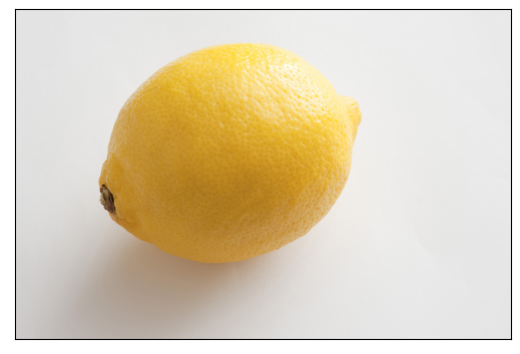

In [4]:
img = mmcv.imread(img_path)
draw_cv2_img(img)

### Initialize model

In [5]:
cfg = Config.fromfile(config_path)
if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, weights_path, map_location='cpu')
classes = cfg.checkpoint_config.meta.CLASSES
obj_classes = {'rect': {}, 'bitmap': {}}
for class_name in classes:
    obj_classes['rect'][class_name] = sly.ObjClass(class_name, sly.Rectangle)
    obj_classes['bitmap'][class_name] = sly.ObjClass(class_name, sly.Bitmap)

model.CLASSES = classes
model.cfg = cfg
model.to(device)
model.eval()
model = revert_sync_batchnorm(model)

load checkpoint from local path: /root/weights.pth


### Inference model

In [6]:
result = inference_detector(model, img_path)

/usr/local/lib/python3.8/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


### Convert model predictions to Supervisely format

In [12]:
ann = convert_preds_to_sly_annotation(
    result, 
    classes,
    obj_classes,
    img_path,
    conf_thresh=0.5,
    add_bboxes=False, 
    add_segm=True
)


### Visualize predictions

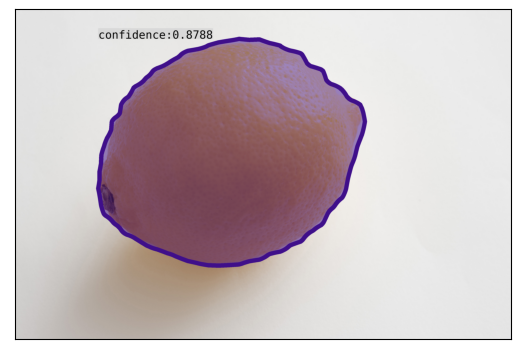

In [14]:
draw_cv2_img(img, ann, opacity=0.5, draw_tags=True, fill_bboxes=False)